# Exploratory Analysis

In [1]:
import random
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
import pickle
import numpy as np
import torchvision
from typing import Tuple

In [2]:
def unpickle(f):
    with open(f, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def new_random_crop(labels, new_crop_size):
    crop_map = create_crop_map(len(labels), new_crop_size)
    good_indices = find_good_samples(labels, crop_map, new_crop_size)
    return crop_map, good_indices


def create_crop_map(data_size, crop_size):
    # The crop map assigns an x_shift and y_shift to each sample in the main 64 x 64 dataset.
    crop_map = []
    for i in range(data_size):
        x_shift = random.randint(0, 64 - crop_size)
        y_shift = random.randint(0, 64 - crop_size)
        crop_map.append((x_shift, y_shift))
    return np.array(crop_map)


def get_cropped_sample(index, crop_map, crop_size, data, labels):
    x_shift, y_shift = crop_map[index]
    cropped_features = data[index, :, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
    cropped_label = labels[index, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
        
    return cropped_features, cropped_label


def find_good_samples(labels, crop_map, crop_size):
    # Finds the indices of samples that have no missing data in their labels.
    # This is determined AFTER generating a crop map and applying the crop to the original 64 x 64 label.
    good_indices = []
    for i in range(len(labels)):
        x_shift, y_shift = crop_map[i]
        if np.all(np.invert(labels[i, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size] == -1)):
            good_indices.append(i)
    return np.array(good_indices)


class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, data_filename, labels_filename, crop_size=32, features=None):
        self.data, self.labels = unpickle(data_filename), unpickle(labels_filename)
        self.crop_size = crop_size

        random.seed(1)
        self.crop_map, self.good_indices = new_random_crop(self.labels, self.crop_size)

        if features:
            assert isinstance(features, list)
        self.features = sorted(features) if features else None
        
        print(f"data size: {self.data.nbytes}")
        print(f"label size: {self.labels.nbytes}")
        print(f"crop_map size: {self.crop_map.nbytes}")
        print(f"good_indices size: {self.good_indices.nbytes}")
        print(f"total size: {self.data.nbytes + self.labels.nbytes + self.crop_map.nbytes + self.good_indices.nbytes}")
        print("finished initializing WildfireDataset")
        
    def __len__(self):
        return len(self.good_indices)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        index = self.good_indices[index]
        
        cropped_features, cropped_label = get_cropped_sample(index, self.crop_map, self.crop_size, self.data, self.labels)

        # Only keep specific features
        if self.features:
            cropped_features = cropped_features[self.features, :, :]

        sample = (torch.from_numpy(cropped_features), torch.from_numpy(np.expand_dims(cropped_label, axis=0)))

        return sample

In [3]:
train_dataset = WildfireDataset("../data/next-day-wildfire-spread/train.data", "../data/next-day-wildfire-spread/train.labels")
test_dataset = WildfireDataset("../data/next-day-wildfire-spread/test.data", "../data/next-day-wildfire-spread/test.labels")
validation_dataset = WildfireDataset("../data/next-day-wildfire-spread/validation.data", "../data/next-day-wildfire-spread/validation.labels")

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=True, num_workers=0)

data size: 2944991232
label size: 245415936
crop_map size: 239664
good_indices size: 98800
total size: 3190745632
finished initializing WildfireDataset
data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 11016
total size: 359781528
finished initializing WildfireDataset
data size: 369033216
label size: 30752768
crop_map size: 30032
good_indices size: 12440
total size: 399828456
finished initializing WildfireDataset


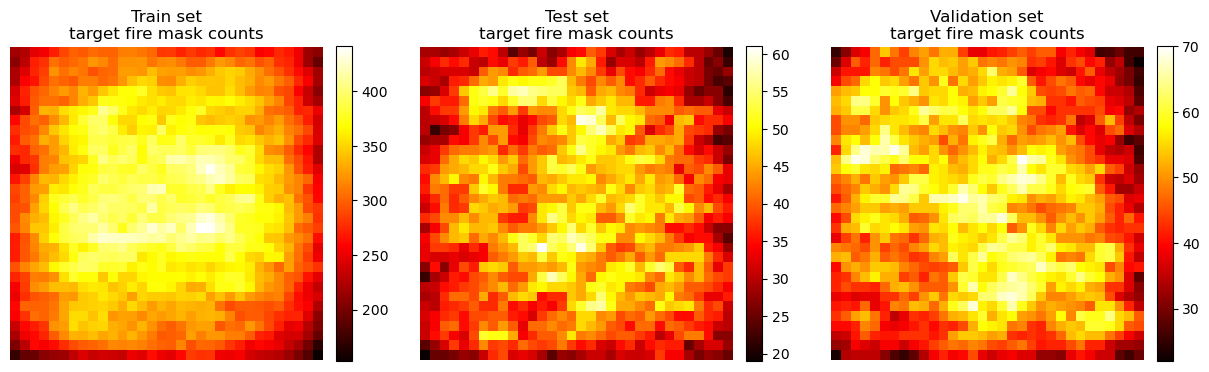

In [4]:
import sys
import numpy
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/3373256/set-colorbar-range-in-matplotlib

def dataset_fire_mask_heat_maps(image_shape, train_loader, test_loader, validation_loader):
    train_heat_map = np.zeros(image_shape)
    test_heat_map = np.zeros(image_shape)
    validation_heat_map = np.zeros(image_shape)
    side_length = image_shape[0]
    
    n_rows = 1
    n_cols = 3
    
    fig = plt.figure(figsize=(15,6.5))
    
    for i, (batch_inputs, batch_labels) in enumerate(train_loader):
        for fire_mask in batch_labels:
            train_heat_map += torch.reshape(fire_mask, image_shape).numpy()
            
    for i, (batch_inputs, batch_labels) in enumerate(test_loader):
        for fire_mask in batch_labels:
            test_heat_map += torch.reshape(fire_mask, image_shape).numpy()
    
    for i, (batch_inputs, batch_labels) in enumerate(validation_loader):
        for fire_mask in batch_labels:
            validation_heat_map += torch.reshape(fire_mask, image_shape).numpy()
        
    plt.subplot(n_rows, n_cols, 1)
    plt.title("Train set\ntarget fire mask counts")
    plt.imshow(train_heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")
    
    plt.subplot(n_rows, n_cols, 2)
    plt.title("Test set\ntarget fire mask counts")
    plt.imshow(test_heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")
    
    plt.subplot(n_rows, n_cols, 3)
    plt.title("Validation set\ntarget fire mask counts")
    plt.imshow(validation_heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

dataset_fire_mask_heat_maps((32, 32), train_loader, test_loader, validation_loader)

data size: 2944991232
label size: 245415936
crop_map size: 239664
good_indices size: 84048
total size: 3190730880
finished initializing WildfireDataset
data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 8896
total size: 359779408
finished initializing WildfireDataset
data size: 369033216
label size: 30752768
crop_map size: 30032
good_indices size: 10720
total size: 399826736
finished initializing WildfireDataset


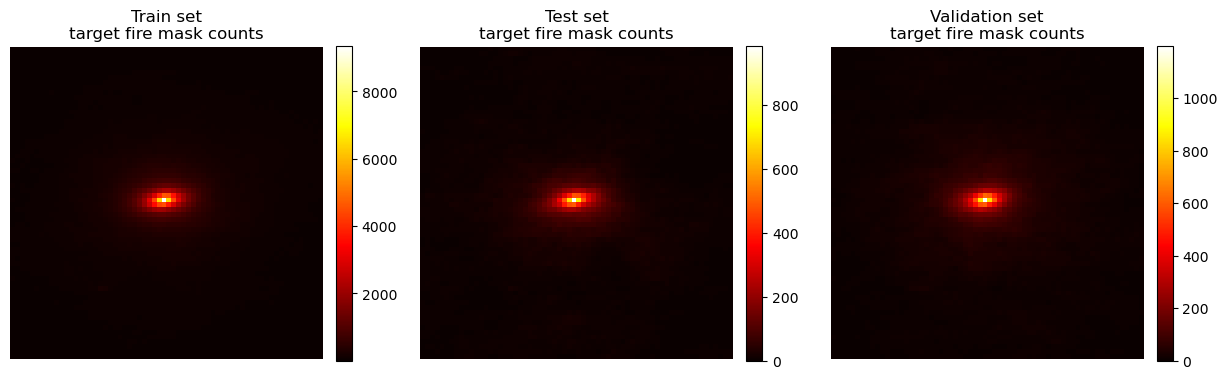

In [5]:
train_dataset = WildfireDataset(data_filename="../data/next-day-wildfire-spread/train.data", 
                                labels_filename="../data/next-day-wildfire-spread/train.labels", 
                                crop_size=64)

test_dataset = WildfireDataset(data_filename="../data/next-day-wildfire-spread/test.data", 
                               labels_filename="../data/next-day-wildfire-spread/test.labels", 
                               crop_size=64)

validation_dataset = WildfireDataset(data_filename="../data/next-day-wildfire-spread/validation.data", 
                                     labels_filename="../data/next-day-wildfire-spread/validation.labels", 
                                     crop_size=64)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=True, num_workers=0)

dataset_fire_mask_heat_maps((64, 64), train_loader, test_loader, validation_loader)